# 门控循环单元（GRU）
门控循环单元支持隐状态的门控。模型具有一些`可学习`的隐状态门控策略，决定是否可以更新和重置隐状态。

## 重置门（reset gate）和更新门（update gate）
重置门允许我们控制“可能还想记住”的过去状态的数量； 更新门将允许我们控制新状态中有多少个是旧状态的副本。

![Alt text](image.png)

给出重置门和更新门的数学表达如下：

![Alt text](image-1.png)

## 候选隐状态

![Alt text](image-2.png)

上面的公式和RNN的区别在于引入了一层重置门$R_t$做Hardmond积。这一点最大的问题是，如果某些项被重置，那么在这一层候选隐状态中，这些被初始化为当前的输入。这样的识别效果有利于实现对前序不重要信息的“遗忘”。

## 隐状态的最终数学形态
![Alt text](image-3.png)

下面给出门运算的运算流：

![Alt text](image-4.png)

可以根据$Z_t$来确定是否需要更新当前的参数（或者记忆当前的参数）。

## GRU的显著特征
重置门有助于捕获序列中的短期依赖关系；

更新门有助于捕获序列中的长期依赖关系。

# 实现

## 读取数据集

In [7]:
!pip install d2l
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 初始化模型参数

In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 定义模型

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

## 实现GRU

In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs: # 根据先前推导出的GRU公式
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

## 训练与预测

perplexity 1.1, 35503.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of him was 
traveller  it s against reason said filby  what reason said


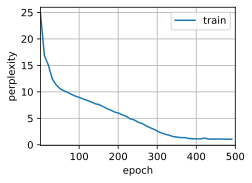

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 调用高级API的简洁实现

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

AttributeError: ignored